# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Part Two Instructions

Add **interpolated smoothing** to your model:  

p(w1|w2) = (0.5 * p_bigram(w1|w2)) + (0.5 * p_unigram(w1))  

Train your model on *wikiOscars.txt* (shared folder). Calculate and print out the probability of each of the following sentences:  

\<s> The first Oscar was presented in 1929 . \</s>  
\<s> The first Oscar was presented in 1929 \</s>  
\<s> The first Oscar was awarded in 1929 . \</s>  
\<s> The Oscar was first awarded in 1929 . \</s>  
\<s> The first best Picture Arts and the . \</s>  
\<s> The party was at the Mayfair Hotel . \</s>  
\<s> The party was changed to the Mayfair . \</s>  
\<s> The party was at the Emil Jannings . \</s>  
\<s> The party was at the Hollywood Hotel . \</s>   

Note that your model does not need to handle unseen unigrams, i.e. all the words that your model will be applied to occur at least once in the training data.

# Part Two

To add interpolated smoothing to the previous model, we simply have to create another Python class which uses interpolated smoothing when calculating the probabilities.

In [2]:
class SmoothedBigramLM:
    """
    Class to represent an unsmoothed bigram LM.
    """

    def __init__(self, corpus=[]):
        """
        Corpus object is a list of the sentences in the corpus as strings.
        Sentence start and end markers appear in each string.
        The unigrams and bigrams are extracted on instantiation.
        """
        self.corpus = corpus
        self.unigram_counts = self.count_unigrams(corpus)
        self.bigram_counts = self.count_bigrams(corpus)

    def count_unigrams(self, corpus):
        """
        Creates a dict with every unigram in the corpus and 
        a count of how many times it appears in the corpus.
        """
        counts = {}
        for s in corpus:
            # Tokenise sentence
            toks = s.split()
            for tok in toks:
                #Normalise case
                tok = tok.casefold()
                if tok in counts:
                    counts[tok] += 1
                else:
                    counts[tok] = 1
        # Return dict with unigram counts
        return counts

    def count_bigrams(self, corpus):
        """
        Creates a dict with every bigram in the corpus and 
        a count of how many times it appears in the corpus.
        """
        counts = {}
        for s in corpus:
            # Tokenise sentence
            toks = s.split()
            for tok1, tok2 in zip(toks, toks[1:]):
                # Normalise case
                tok1 = tok1.casefold()
                tok2 = tok2.casefold()
                bigram = (tok1, tok2)
                if bigram in counts:
                    counts[bigram] += 1
                else:
                    counts[bigram] = 1
        #Return dict with bigram counts
        return counts
        
                 
    def p_unigram(self, word):
        """
        Returns the probability of a unigram w.
        """
        # Strip whitespace and normalise case
        w = word.strip().casefold()

        # Make sure w is only one word
        if len(w.split()) > 1:
            raise ValueError

        #  p(w) = count("w") / count(unigrams)
        return self.unigram_counts[w] / sum(self.unigram_counts.values())
    
    def p_bigram(self, word, prev_word):
        """
        Returns the probability of a bigram - "prev_word word".
        """
        # Strip whitespace and normalise case
        w1 = prev_word.strip().casefold()
        w2 = word.strip().casefold()

        # Make sure both are one word
        if (len(w1.split()) > 1) or (len(w2.split()) > 1):
            raise ValueError
            
        # If bigram has been seen before
        try:
            # p(w2 | w1) = count("w1 w2") / count("w1")
            bigram = (w1, w2)
            return self.bigram_counts[bigram] / self.unigram_counts[w1]
        
        # If bigram unseen
        except KeyError:
            return 0

    def p_word_seq(self, s):
        """
        Returns the probability of a word sequence s.
        """
        # Strip whitespace, normalise case and tokenise
        toks = s.strip().casefold().split()
        
        # Initialise list to store probabilities
        probs = []
        probs.append(self.p_unigram(toks[0]))
        for prev, curr in zip(toks, toks[1:]):
            # Add interpolated smoothing
            probs.append((0.5 * self.p_bigram(curr, prev)) + (0.5 * self.p_unigram(curr)))
        
        #Return product of probs
        return np.prod(probs), self.p_log_space(probs)
    
    def p_log_space(self, probs):
        """
        Returns the log probability of list of word probabilities.
        """
        total = 0
        for p in probs:
            total += np.log(p)
        return total

Nextly, I'm going to read in the *wikiOscars.txt* corpus and instantiate the model. Each sentence should have the following structure based on what the unseen sentences look like:  
  
"\<s> [INSERT SENTENCE] . \</s>"  

This requires some processing which is done below:

In [3]:
oscars_corpus = []

filename = r"./data/wikiOscars.txt"
with open(filename) as f:
    for line in f:
        # Strip newline and split sentences
        sentences = line.rstrip("\n").split(".")[:-1]
        for s in sentences:
            # Add sentence markers
            oscars_corpus.append("<s> " + s.strip() + " . </s>")

In [4]:
oscars_corpus

['<s> The Academy Awards , commonly known as The Oscars , is an annual American awards ceremony honoring achievements in the film industry . </s>',
 '<s> Winners are awarded the statuette , officially the Academy Award of Merit , that is much better known by its nickname Oscar . </s>',
 '<s> The awards , first presented in 1929 at the Hollywood Roosevelt Hotel , are overseen by the Academy of Motion Picture Arts and Sciences (AMPAS) . </s>',
 '<s> The awards ceremony was first televised in 1953 and is now seen live in more than 200 countries . </s>',
 '<s> The Oscars is also the oldest entertainment awards ceremony ; its equivalents , the Emmy Awards for television , the Tony Awards for theatre , and the Grammy Awards for music and recording , are modeled after the Academy Awards . </s>',
 '<s> The 86th Academy Awards were held on March 2 , 2014 , at the Dolby Theatre in Los Angeles . </s>',
 '<s> The first Academy Awards were presented on May 16 , 1929 , at a private dinner at the Hol

Now, we can instantiate the Smoothed Bigram LM...

In [5]:
LM = SmoothedBigramLM(oscars_corpus)

Checking the unigram and bigram counts...

In [6]:
LM.unigram_counts

{'<s>': 22,
 'the': 60,
 'academy': 12,
 'awards': 16,
 ',': 28,
 'commonly': 1,
 'known': 2,
 'as': 3,
 'oscars': 3,
 'is': 4,
 'an': 2,
 'annual': 1,
 'american': 1,
 'ceremony': 10,
 'honoring': 2,
 'achievements': 1,
 'in': 14,
 'film': 3,
 'industry': 2,
 '.': 22,
 '</s>': 22,
 'winners': 4,
 'are': 3,
 'awarded': 4,
 'statuette': 1,
 'officially': 1,
 'award': 5,
 'of': 14,
 'merit': 1,
 'that': 5,
 'much': 1,
 'better': 1,
 'by': 2,
 'its': 2,
 'nickname': 1,
 'oscar': 2,
 'first': 7,
 'presented': 2,
 '1929': 2,
 'at': 7,
 'hollywood': 2,
 'roosevelt': 2,
 'hotel': 3,
 'overseen': 1,
 'motion': 1,
 'picture': 2,
 'arts': 1,
 'and': 9,
 'sciences': 1,
 '(ampas)': 1,
 'was': 7,
 'televised': 1,
 '1953': 1,
 'now': 1,
 'seen': 1,
 'live': 1,
 'more': 1,
 'than': 1,
 '200': 1,
 'countries': 1,
 'also': 1,
 'oldest': 1,
 'entertainment': 1,
 ';': 6,
 'equivalents': 1,
 'emmy': 1,
 'for': 17,
 'television': 1,
 'tony': 1,
 'theatre': 2,
 'grammy': 1,
 'music': 1,
 'recording': 1,
 'm

In [7]:
LM.bigram_counts

{('<s>', 'the'): 10,
 ('the', 'academy'): 7,
 ('academy', 'awards'): 7,
 ('awards', ','): 2,
 (',', 'commonly'): 1,
 ('commonly', 'known'): 1,
 ('known', 'as'): 1,
 ('as', 'the'): 1,
 ('the', 'oscars'): 2,
 ('oscars', ','): 1,
 (',', 'is'): 1,
 ('is', 'an'): 1,
 ('an', 'annual'): 1,
 ('annual', 'american'): 1,
 ('american', 'awards'): 1,
 ('awards', 'ceremony'): 4,
 ('ceremony', 'honoring'): 1,
 ('honoring', 'achievements'): 1,
 ('achievements', 'in'): 1,
 ('in', 'the'): 3,
 ('the', 'film'): 1,
 ('film', 'industry'): 1,
 ('industry', '.'): 1,
 ('.', '</s>'): 22,
 ('<s>', 'winners'): 2,
 ('winners', 'are'): 1,
 ('are', 'awarded'): 1,
 ('awarded', 'the'): 1,
 ('the', 'statuette'): 1,
 ('statuette', ','): 1,
 (',', 'officially'): 1,
 ('officially', 'the'): 1,
 ('academy', 'award'): 2,
 ('award', 'of'): 1,
 ('of', 'merit'): 1,
 ('merit', ','): 1,
 (',', 'that'): 2,
 ('that', 'is'): 1,
 ('is', 'much'): 1,
 ('much', 'better'): 1,
 ('better', 'known'): 1,
 ('known', 'by'): 1,
 ('by', 'its'): 

## Calculating Probabilities

Next, we must calculate and print out the probability of each of the following sentences:

\<s> The first Oscar was presented in 1929 . \</s>  
\<s> The first Oscar was presented in 1929 \</s>  
\<s> The first Oscar was awarded in 1929 . \</s>  
\<s> The Oscar was first awarded in 1929 . \</s>   
\<s> The first best Picture Arts and the . \</s>  
\<s> The party was at the Mayfair Hotel . \</s>  
\<s> The party was changed to the Mayfair . \</s>  
\<s> The party was at the Emil Jannings . \</s>  
\<s> The party was at the Hollywood Hotel . \</s> 

In [8]:
# Initialise list to store probabilities
probs = []

In [9]:
s1 = "<s> The first Oscar was presented in 1929 . </s>"

print("String: ", s1)
prob, log_prob = LM.p_word_seq(s1)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s1", s1, prob, log_prob])

String:  <s> The first Oscar was presented in 1929 . </s>
Probability:  6.769058634165556e-16
Log Probability:  -34.928999460255106


In [10]:
s2 = "<s> The first Oscar was presented in 1929 </s>"

print("String: ", s2)
prob, log_prob = LM.p_word_seq(s2)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s2", s2, prob, log_prob])

String:  <s> The first Oscar was presented in 1929 </s>
Probability:  1.306535761769098e-15
Log Probability:  -34.271397217114576


In [11]:
s3 = "<s> The first Oscar was awarded in 1929 . </s>"

print("String: ", s3)
prob, log_prob = LM.p_word_seq(s3)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s3", s3, prob, log_prob])

String:  <s> The first Oscar was awarded in 1929 . </s>
Probability:  5.960177413730679e-17
Log Probability:  -37.35884633286008


In [12]:
s4 = "<s> The Oscar was first awarded in 1929 . </s>"

print("String: ", s4)
prob, log_prob = LM.p_word_seq(s4)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s4", s4, prob, log_prob])

String:  <s> The Oscar was first awarded in 1929 . </s>
Probability:  9.700668606493119e-17
Log Probability:  -36.871751769260456


In [13]:
s5 = "<s> The first best Picture Arts and the . </s>"

print("String: ", s5)
prob, log_prob = LM.p_word_seq(s5)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s5", s5, prob, log_prob])

String:  <s> The first best Picture Arts and the . </s>
Probability:  1.130006058830593e-09
Log Probability:  -20.60104284243955


In [14]:
s6 = "<s> The party was at the Mayfair Hotel . </s>"

print("String: ", s6)
prob, log_prob = LM.p_word_seq(s6)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s6", s6, prob, log_prob])

String:  <s> The party was at the Mayfair Hotel . </s>
Probability:  4.289659239331535e-12
Log Probability:  -26.174813817534716


In [15]:
s7 = "<s> The party was changed to the Mayfair . </s>"

print("String: ", s7)
prob, log_prob = LM.p_word_seq(s7)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s7", s7, prob, log_prob])

String:  <s> The party was changed to the Mayfair . </s>
Probability:  1.8149931216255725e-14
Log Probability:  -31.64010962394499


In [16]:
s8 = "<s> The party was at the Emil Jannings . </s>"

print("String: ", s8)
prob, log_prob = LM.p_word_seq(s8)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s8", s8, prob, log_prob])

String:  <s> The party was at the Emil Jannings . </s>
Probability:  3.7667799136810396e-14
Log Probability:  -30.90997079973938


In [17]:
s9 = "<s> The party was at the Hollywood Hotel . </s> "

print("String: ", s9)
prob, log_prob = LM.p_word_seq(s9)
print("Probability: ", prob)
print("Log Probability: ", log_prob)

probs.append(["s9", s9, prob, log_prob])

String:  <s> The party was at the Hollywood Hotel . </s> 
Probability:  4.212431331585796e-14
Log Probability:  -30.798151307478257


## Plot of Probabilities  

As before, we can also plot the probabilities on a bar chart to see how the sentences compare to each other in terms of how probable they are.

In [18]:
df_probs = pd.DataFrame.from_records(probs, columns=["sentence", "text", "prob", "log_prob"])

In [19]:
df_probs

,sentence,text,prob,log_prob
0,s1,<s> The first Oscar was presented in 1929 . </s>,6.769059e-16,-34.928999
1,s2,<s> The first Oscar was presented in 1929 </s>,1.306536e-15,-34.271397
2,s3,<s> The first Oscar was awarded in 1929 . </s>,5.960177e-17,-37.358846
3,s4,<s> The Oscar was first awarded in 1929 . </s>,9.700669e-17,-36.871752
4,s5,<s> The first best Picture Arts and the . </s>,1.130006e-09,-20.601043
5,s6,<s> The party was at the Mayfair Hotel . </s>,4.289659e-12,-26.174814
6,s7,<s> The party was changed to the Mayfair . </s>,1.814993e-14,-31.640110
7,s8,<s> The party was at the Emil Jannings . </s>,3.766780e-14,-30.909971
8,s9,<s> The party was at the Hollywood Hotel . </s>,4.212431e-14,-30.798151


<AxesSubplot:xlabel='sentence', ylabel='log_prob'>

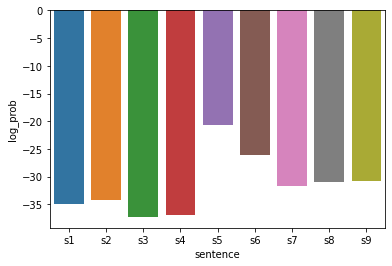

In [20]:
sns.barplot(x="sentence", y="log_prob", data=df_probs)

The plot of the normal probabilities is not very informative in this case... hence why calculating in log space is useful.

<AxesSubplot:xlabel='sentence', ylabel='prob'>

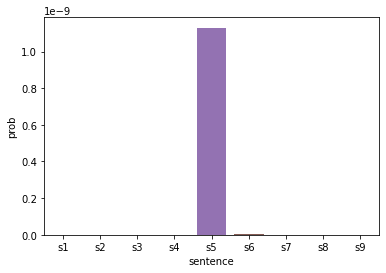

In [21]:
sns.barplot(x="sentence", y="prob", data=df_probs)